In [1]:
import os

import numpy as np
import importlib
import seaborn as sns
import gymnasium as gym
import matplotlib.pyplot as plt

import gym_env
from models import SR_IS
from utils import get_full_maze_values, policy_reval, decision_policy, update_terminal_reward
from utils_render import plot_decision_prob

In [2]:
# Set the random seed for NumPy
seed = 1
np.random.seed(seed)

# Save dir
save_dir = os.path.join('..', 'figures/')

# For plotting
idx = 4
prob_locs = [3, 5]
colors = [1, 9]

## DR Complete Agent

In [3]:
# Agent to be used with D_inv
agent = SR_IS(env_name="tolman-latent", reward=-1, term_reward=5)
# Make the reward for the first terminal state higher than the second to bias the DR towards that terminal state
# update_terminal_reward(agent, loc=0, r=5)
# update_terminal_reward(agent, loc=1, r=5)

agent.DR = agent.gamma * agent.get_D_inv()
agent.update_V()
maze_values = get_full_maze_values(agent)

In [4]:
pii_old = decision_policy(agent, agent.Z)

In [5]:
pii_old[4]
print(f"Prob left: {pii_old[4][3]} | Prob right: {pii_old[4][5]}")

Prob left: 0.4883122491710901 | Prob right: 0.4883122491710901


In [6]:
# Make the reward for the first terminal state negative and recalculate policy
update_terminal_reward(agent, loc=0, r=-5)
V_new, Z_new = policy_reval(agent)

In [7]:
pii_new = decision_policy(agent, Z_new)

In [8]:
print(f"Prob left: {pii_new[4][3]} | Prob right: {pii_new[4][5]}")

Prob left: 0.02341663522531297 | Prob right: 0.9532078631168673


## With Importance Sampling

In [26]:
# Model Hyperparams
reward = -1
terminal_reward = 5
alpha = 0.2
beta = 1.0
_lambda = 1.0
num_steps = 5000
num_iterations = 30

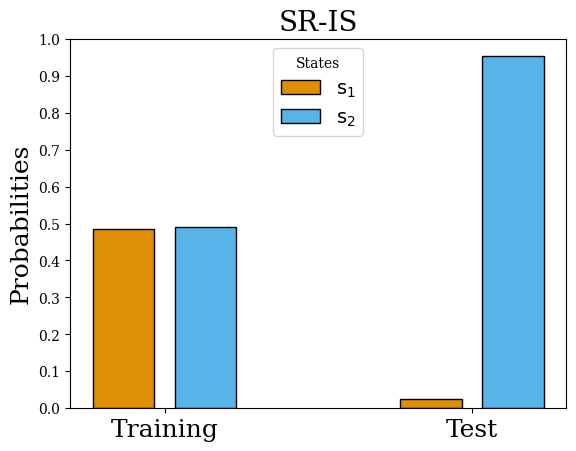

In [29]:
prob_train, prob_test = np.array([0.0,0.0]), np.array([0.0,0.0])

for i in range(num_iterations):
    # Agent
    agent = SR_IS(env_name="tolman-latent", reward=reward, term_reward=terminal_reward, _lambda=_lambda, beta=beta, alpha=alpha, num_steps=num_steps, policy="softmax", imp_samp=True)
    agent.learn(seed=i)

    # Old policy
    pii_old = decision_policy(agent, agent.Z)
    prob_train[0] += pii_old[4][3]
    prob_train[1] += pii_old[4][5]
    # print(f"Prob left: {pii_old[4][3]} | Prob right: {pii_old[4][5]}")

    # Make the reward for the first terminal state negative and recalculate policy
    update_terminal_reward(agent, loc=0, r=-5)
    V_new, Z_new = policy_reval(agent)

    # New policy
    pii_new = decision_policy(agent, Z_new)
    prob_test[0] += pii_new[4][3]
    prob_test[1] += pii_new[4][5]
    # print(f"Prob left: {pii_new[4][3]} | Prob right: {pii_new[4][5]}")

# Plot
prob_train /= num_iterations
prob_test /= num_iterations
# save_path = save_dir + "latent_with_is.png"
save_path = None
plot_decision_prob(probs_train=prob_train, probs_test=prob_test, colors=colors, title='SR-IS', leg_loc="upper center", save_path=save_path)

## Without Importance Sampling

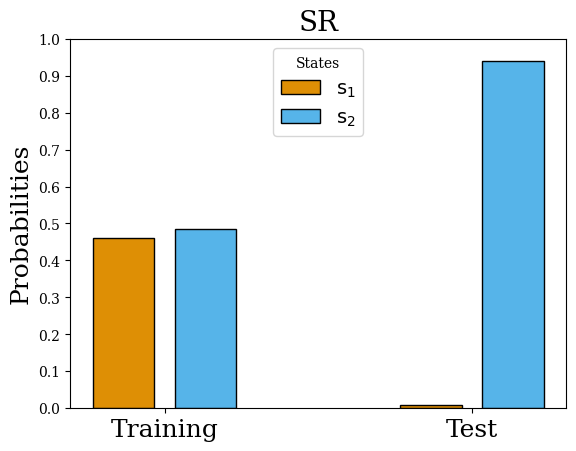

In [30]:
prob_train, prob_test = np.array([0.0,0.0]), np.array([0.0,0.0])

for i in range(num_iterations):
    # Agent
    agent = SR_IS(env_name="tolman-latent", reward=reward, term_reward=terminal_reward, _lambda=_lambda, beta=beta, alpha=alpha, num_steps=num_steps, policy="softmax", imp_samp=False)
    agent.learn(seed=i)

    # Old policy
    pii_old = decision_policy(agent, agent.Z)
    # print(f"Prob left: {pii_old[4][3]} | Prob right: {pii_old[4][5]}")
    prob_train[0] += pii_old[4][3]
    prob_train[1] += pii_old[4][5]

    # Make the reward for the first terminal state negative and recalculate policy
    update_terminal_reward(agent, loc=0, r=-5)
    V_new, Z_new = policy_reval(agent)

    # New policy
    pii_new = decision_policy(agent, Z_new)
    # print(f"Prob left: {pii_new[4][3]} | Prob right: {pii_new[4][5]}")
    prob_test[0] += pii_new[4][3]
    prob_test[1] += pii_new[4][5]

prob_train /= num_iterations
prob_test /= num_iterations
# Plot
save_path = save_dir + "latent_without_is.png"
# save_path = None
plot_decision_prob(probs_train=prob_train, probs_test=prob_test, colors=colors, title='SR', leg_loc="upper center", save_path=save_path)